In [2]:
import sys
sys.path.append("..")
from flame_analysis_model import *

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.manifold import SpectralEmbedding, TSNE, MDS

import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

import hdbscan


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Read data

In [4]:
df = pd.read_csv("flame_front_po_post0.csv")
print(df.keys())
# Select meaningful physical variables
features = ['v', 'T', 'u', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2' ]

X = StandardScaler().fit_transform(df[features])
colourmap = X[:, 5]
print(colourmap)

Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'omega_H2',
       'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH', 'omega_HO2',
       'omega_H2O2', 'omega_N2', 'Le_def'],
      dtype='object')
[-0.1541793  -0.15667013 -0.26450046 ...  0.02450068  0.34387982
 -0.01400064]


## UMAP

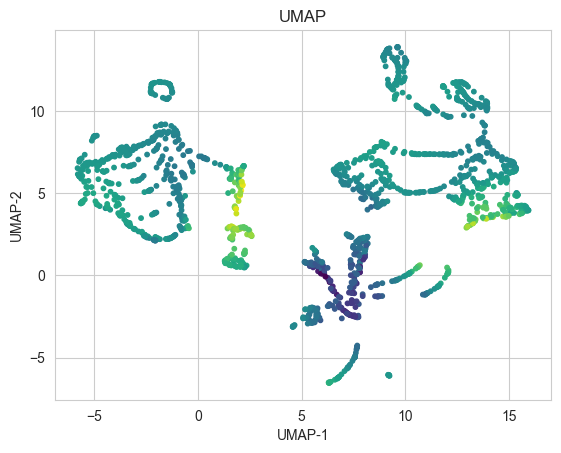

In [5]:
# UMAP embedding
reducer = umap.UMAP(n_neighbors=10, n_components=2)
X_embedded = reducer.fit_transform(X)
# Plot
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## UMAP -> HDBSCAN -> MI -> Mapping to original space
Taken from "Identifying key features in reactive flows: A tutorial on combining
dimensionality reduction, unsupervised clustering, and feature correlation"

Cluster summary: {np.int64(-1): np.int64(7), np.int64(0): np.int64(191), np.int64(1): np.int64(540), np.int64(2): np.int64(410), np.int64(3): np.int64(666)}
Number of clusters (excluding noise): 4
Noise fraction: 0.003858875413450937
Average cluster probability: 0.9434982611883466


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


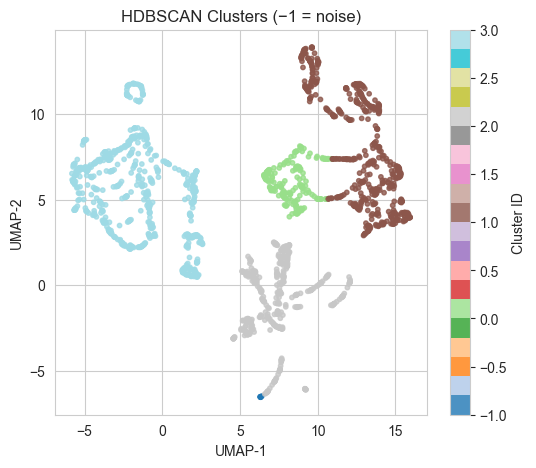

In [6]:
# HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size= int(np.sqrt(len(X))),  #smallest "real" cluster (heuristic: ~0.5–2% of n)
    min_samples= int(np.sqrt(len(X))),       # sensitivity to noise (heuristic: ~dimensionality or 5–30)
    metric='euclidean',
    cluster_selection_method='eom',           # use 'leaf' for more/smaller clusters
    prediction_data=True                      # enables assigning new points later
).fit(X_embedded)

labels = clusterer.labels_                    # -1 means noise
proba  = clusterer.probabilities_             # per-point cluster confidence [0,1]
outlier_scores = clusterer.outlier_scores_    # higher => more outlier-like


unique, counts = np.unique(labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster summary:", cluster_summary)
print("Number of clusters (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise fraction:", np.mean(labels == -1))
print("Average cluster probability:", proba[labels != -1].mean() if np.any(labels != -1) else 0)

plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_embedded[:,0], X_embedded[:,1],
    c=labels, cmap='tab20', s=10, alpha=0.8
)
plt.title("HDBSCAN Clusters (−1 = noise)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

Global mutual information ranking:
   feature   MI_dim1   MI_dim2    MI_sum
4     dudy  1.660565  1.518424  3.178988
3     dudx  1.438330  1.656431  3.094761
2        u  1.415064  1.630035  3.045099
10       H  1.523057  1.468224  2.991281
14    H2O2  1.346529  1.642006  2.988535
0        v  1.494252  1.493344  2.987596
13     HO2  1.285478  1.696795  2.982273
7       H2  1.260062  1.578691  2.838753
12      OH  1.382510  1.337577  2.720087
11       O  1.393491  1.291366  2.684856


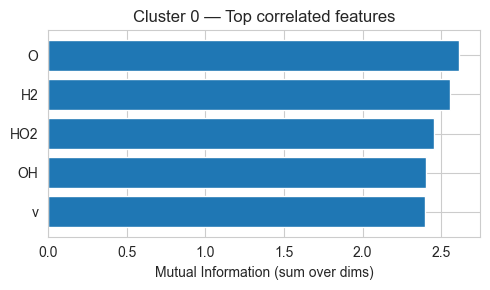

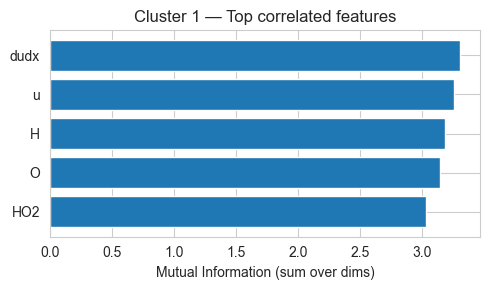

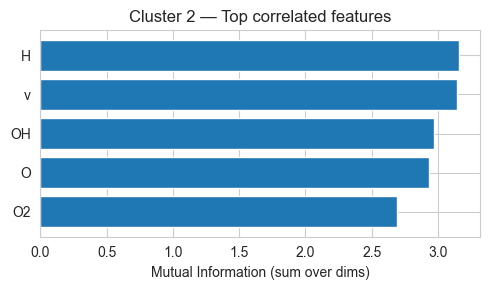

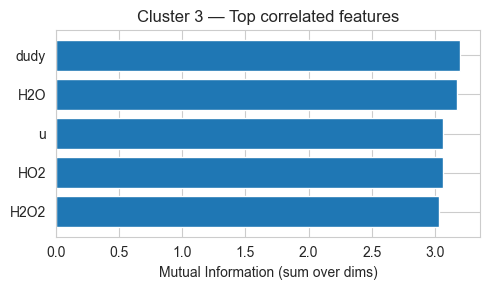

In [7]:
from sklearn.feature_selection import mutual_info_regression
mi_x1 = mutual_info_regression(X, X_embedded[:, 0], random_state=0)
mi_x2 = mutual_info_regression(X, X_embedded[:, 1], random_state=0)

df_mi_global = pd.DataFrame({
    'feature': features,
    'MI_dim1': mi_x1,
    'MI_dim2': mi_x2,
    'MI_sum':  mi_x1 + mi_x2
}).sort_values('MI_sum', ascending=False)

print("Global mutual information ranking:")
print(df_mi_global.head(10))

cluster_labels = sorted(set(labels) - {-1})   # exclude noise

mi_cluster = {}

for cluster in cluster_labels:
    mask = labels == cluster
    if mask.sum() < 10:   # skip tiny clusters
        continue
    mi1 = mutual_info_regression(X[mask], X_embedded[mask, 0], random_state=0)
    mi2 = mutual_info_regression(X[mask], X_embedded[mask, 1], random_state=0)
    df_new = pd.DataFrame({
        'feature': features,
        'MI_dim1': mi1,
        'MI_dim2': mi2,
        'MI_sum':  mi1 + mi2
    }).sort_values('MI_sum', ascending=False)
    mi_cluster[cluster] = df_new


for cluster, df_new in mi_cluster.items():
    top = df_new.head(5)
    plt.figure(figsize=(5,3))
    plt.barh(top['feature'][::-1], top['MI_sum'][::-1])
    plt.xlabel("Mutual Information (sum over dims)")
    plt.title(f"Cluster {cluster} — Top correlated features")
    plt.tight_layout()
    plt.show()



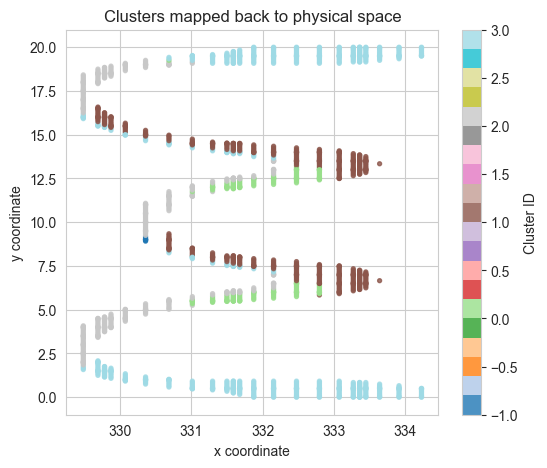

                v         T         u      dudx      dudy      dvdx      dvdy  \
cluster                                                                         
-1       0.038340  3.042026  3.406896  4.781005  1.099544  0.717353  0.166439   
 0      -0.409284  3.918201  5.456264  1.001331 -0.962432 -0.066054  0.367646   
 1       0.168264  4.049685  5.482234  1.107194  0.631977  0.202575  0.277269   
 2      -0.182331  3.589305  4.304909  3.643461 -1.326055 -0.742165  0.457817   
 3       0.092789  3.756529  5.486354  1.136022  0.568383  0.304042  0.607713   

               H2        O2       H2O         H         O        OH       HO2  \
cluster                                                                         
-1       0.002871  0.184993  0.057153  0.000018  0.000137  0.000172  0.000169   
 0       0.000653  0.159219  0.082620  0.000026  0.000542  0.000615  0.000059   
 1       0.000519  0.156185  0.086241  0.000025  0.000489  0.000633  0.000045   
 2       0.001726  0.166633

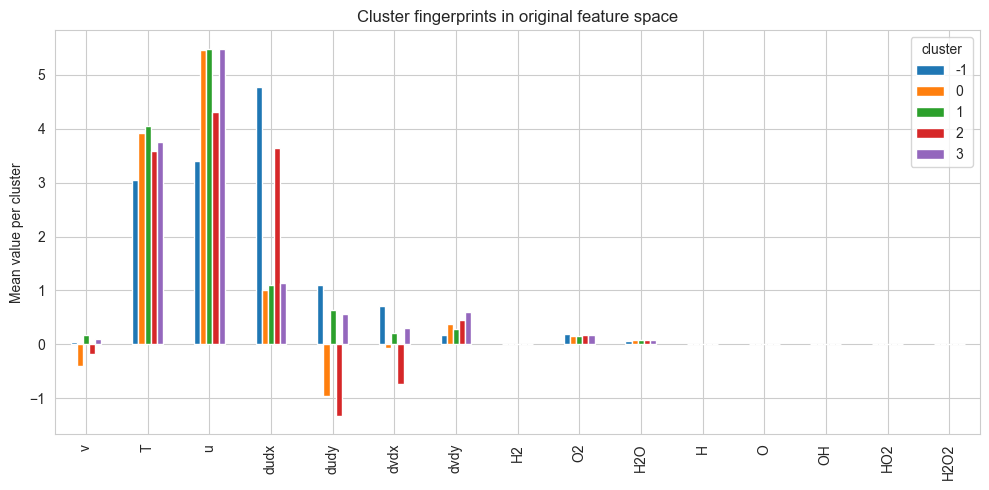

In [8]:
# --- Map clusters back to the original space ---
plt.figure(figsize=(6,5))
plt.scatter(
    df["x"], df["y"],
    c=labels, cmap='tab20', s=8, alpha=0.8
)
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.title("Clusters mapped back to physical space")
plt.colorbar(label="Cluster ID")

plt.show()

# --- Attach cluster labels to the original DataFrame ---
df_with_labels = df.copy()
df_with_labels["cluster"] = labels

# --- Compute physical statistics per cluster ---
cluster_means = df_with_labels.groupby("cluster")[features].mean()
cluster_stds  = df_with_labels.groupby("cluster")[features].std()

print(cluster_means.head())

# --- Plot cluster fingerprints ---
cluster_means.T.plot(kind='bar', figsize=(10,5))
plt.ylabel("Mean value per cluster")
plt.title("Cluster fingerprints in original feature space")
plt.tight_layout()
plt.show()


## Spectral Embedding

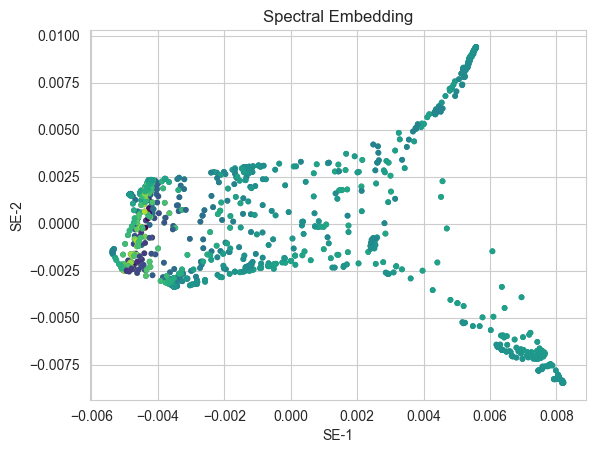

In [9]:
SE = SpectralEmbedding(n_components=2, n_neighbors=30)
X_SE = SE.fit_transform(X)
# Plot
plt.scatter(X_SE[:,0], X_SE[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("Spectral Embedding")
plt.xlabel("SE-1")
plt.ylabel("SE-2")
plt.show()

## t-SNE

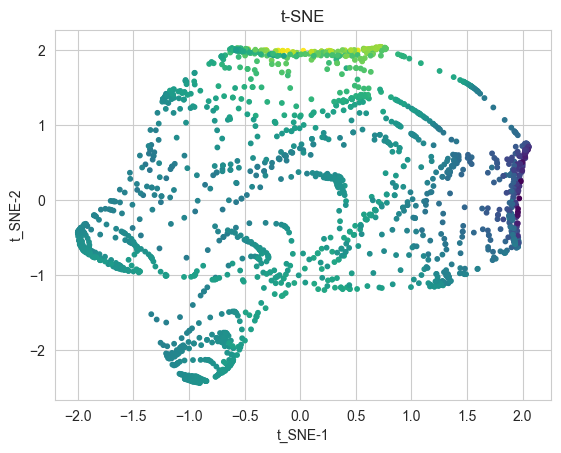

In [10]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    max_iter=250,
    random_state=0,
)
X_sne = t_sne.fit_transform(X)

plt.scatter(X_sne[:,0], X_sne[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("t-SNE")
plt.xlabel("t_SNE-1")
plt.ylabel("t_SNE-2")
plt.show()


## Multidimensional Scaling

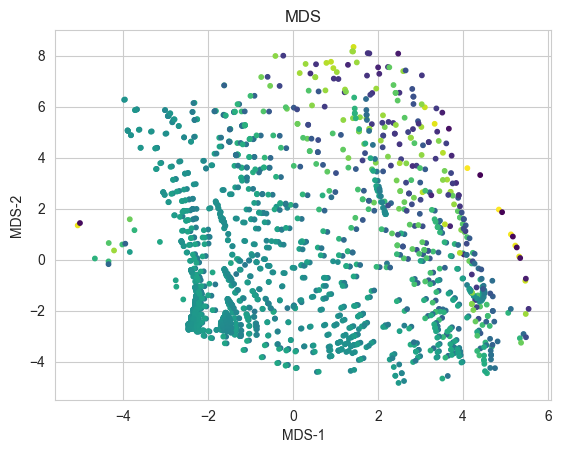

In [11]:
mds_embedding = MDS(n_components=2, n_init=1)
X_mds = mds_embedding.fit_transform(X)

plt.scatter(X_mds[:,0], X_mds[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("MDS")
plt.xlabel("MDS-1")
plt.ylabel("MDS-2")
plt.show()
